In [32]:
import numpy as np
import zarr
import matplotlib.pyplot as plt

RUNTIME = 1800 #seconds
root = zarr.open("../../results.zarr", mode="r")
root.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='cumberland_6', nodes=(Node(disabled…

In [25]:
def analyzeRun(run: zarr.hierarchy):
    # print(f"Analyze {run.name}")

    numNodes = run["graph"].shape[0]
    numAgents = run["origins"].shape[0]

    times = np.array(run["visits"]["time_ns"]) / 1.0e9 #seconds to ns
    data = np.transpose(np.vstack([times, run["visits"]["agent"], run["visits"]["node"]]))
    # print(data.shape)
    # print(data[np.where(data[:,2] == 5)])

    idleness = np.ndarray((RUNTIME + 1, numNodes + 1))
    idleness[:,0] = range(RUNTIME + 1)
    for i in range(numNodes):
        nodeVisits = data[np.where(data[:,2] == i)]

        # Add beginning and end.
        nodeVisits = np.append([[0, 0, i]], nodeVisits, axis=0)
        nodeVisits = np.append(nodeVisits, [[RUNTIME, 0, i]], axis=0)

        # nodeIdleness = []
        idl = 0.0
        visitIdx = 0

        for t in range(RUNTIME + 1):
            if visitIdx + 1 < nodeVisits.shape[0] and t > nodeVisits[visitIdx + 1][0]:
                visitIdx += 1
            idl = t - nodeVisits[visitIdx][0] 
            idleness[t][i + 1] = idl

    return idleness

def analyzeAlg(alg):
    idleness = np.ndarray((RUNTIME + 1, 1))
    idleness[:,0] = range(RUNTIME + 1)
    for run in alg:
        idl = analyzeRun(alg[run])
        # displayAverageIdleness([idl])
        # print(idl.shape)
        idleness = np.concatenate([idleness, idl[:,1:]], axis=1)
    return idleness

def displayAverageIdleness(inputs, labels):
    plt.figure(figsize=(10, 6))
    for arr, name in zip(inputs, labels):
        plt.plot(np.mean(arr[:,1:], axis=1), label=name)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Average Instantaneous Idleness (s)")
    plt.show()

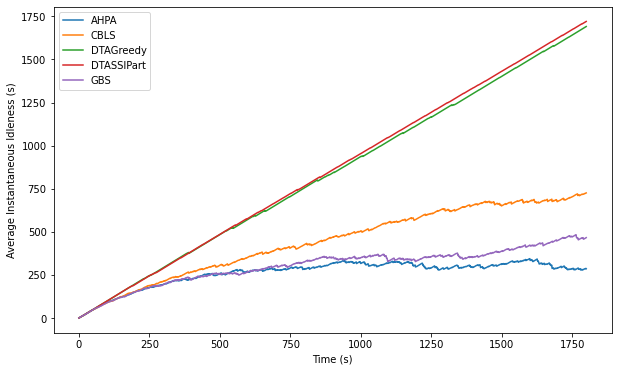

In [26]:
mapName = "cumberland_6"
labels = []
results = []
for algName in root[mapName]:
    res = analyzeAlg(root[mapName][algName])
    results.append(res)
    labels.append(algName)

displayAverageIdleness(results, labels)
